# *1st Assignment*
# ***Georgios Tzamouranis 03121141***
# Image and Video Technology and Analysis
# *ECE NTUA 2025*


#1. Theoretical Part

**a) How does the value of 'a' affect the Gaussian pyramid?**  
The value of 'a' determines the shape of the generating kernel used to create the Gaussian pyramid. Specifically, smaller values (e.g., 0.4) result in a smoother, more Gaussian-like distribution, while higher values (e.g., 0.6) produce a kernel with a sharper central peak and small negative side lobes. This affects the performance of the filter as well as the frequency representation at each level. For example, when a = 0.6 the image is sharper, and edges appear more pronounced, while for smaller values the image becomes blurrier.

**b) What do we define as entropy? Calculate the maximum entropy value a grayscale image can have.**

(The minimum number of bits/pixel required to exactly encode the image, assuming that the pixel values of an image representation are statistically independent (from the paper))  
Entropy is defined as the measure of the average information contained in each pixel, and is computed by the formula:  
  H = –∑ f(i) log₂ f(i) (for i=0 to 255),  
where f(i) is the probability of occurrence of each gray level. For a grayscale image with 256 levels, the maximum entropy is 8 bits/pixel, achieved when all gray levels appear with equal probability 1/256.

**c) How does the choice of bin size affect the result of quantization?**  
The bin size determines how coarse or fine the quantization will be. Larger bins create wider value intervals, leading to a greater loss of detail and possibly visible artifacts, but also higher compression (fewer bits). This happens because more pixels get assigned the same value (the median of the bin). Conversely, smaller bins preserve more detail and produce smaller errors, but require more bits to represent the image.

**d) Effect of the number of pyramid levels on quantization**  
The bin size becomes smaller as we ascend the pyramid. This is because generally the bin size at a given pyramid level reflects human sensitivity to differences at the corresponding frequency band. Humans are more sensitive to low and medium spatial frequencies, and less sensitive to high spatial frequencies. As we ascend the pyramid, we encounter lower frequencies because the image has passed through multiple low-pass filters. Therefore, at higher pyramid levels, more quantization levels (i.e., more, smaller bins) must be used compared to lower levels to achieve smaller error, which in turn is less perceptible by the human eye.




#2. Laboratory Part

1. The function `GKernel(a)` creates the "generating kernel" used for constructing the Gaussian pyramid. Specifically, it defines a 1D kernel of size 5, centered at position 2, computed based on the parameter 'a'. Then, the 2D 5x5 kernel is generated as the outer product of the 1D kernel with itself. This kernel defines the weights for creating each pyramid level, as described on page 533 of the Burt & Adelson paper.

In [ ]:
import numpy as np
def GKernel(a):  # (pattern of weights to generate each pyramid array from its predecessor)

    # Define the 1D kernel (centered at index 2 for size 5)
    w1d = np.array([1/4 - a/2, 1/4, a, 1/4, 1/4 - a/2])

    # Create the 2D kernel as the outer product of the 1D kernel with itself
    h = np.outer(w1d, w1d)
    return h

2. The function `GREDUCE(I, h)` applies convolution of the input image `I` with the kernel `h`, and then performs downsampling by a factor of 2 (selecting every second pixel in both dimensions). This corresponds to equation (1) on page 533 of Burt & Adelson and aims to create the Gaussian pyramid. The function supports both grayscale (2D) and color (3D) images by applying convolution to each channel separately.

In [ ]:
import cv2


def GREDUCE(I, h):
    # For grayscale images (2D)
    if I.ndim == 2:
        # Convolve the image with the kernel h using symmetric boundaries
        conv_image = signal.convolve2d(I, h, mode="same", boundary="symm")
        # Downsample the image by selecting every second pixel in both dimensions
        I_out = conv_image[::2, ::2]
        return I_out

    # For color images (3D)
    elif I.ndim == 3:
        channels = []
        for c in range(I.shape[2]):
            conv_channel = signal.convolve2d(I[:, :, c], h, mode="same", boundary="symm")
            downsampled_channel = conv_channel[::2, ::2]
            channels.append(downsampled_channel)
        # Stack the channels back together to form the color image
        I_out = np.stack(channels, axis=2)
        return I_out

3. The function `GPyramid(I, a, depth)` creates the Gaussian pyramid of an image. It takes as input the image `I`, the parameter `a` used to create the generating kernel (via `GKernel(a)`), and the desired pyramid depth (`depth`). The process starts from the original image and repeatedly applies `GREDUCE` to reduce the image resolution. The result is a list of images, where the first element is the original image and the rest are progressively reduced versions, according to Burt & Adelson's method.

In [ ]:
def GPyramid(I, a, depth):
    # Generate the kernel using the parameter a
    h = GKernel(a)

    # Initialize the pyramid list with the original image
    pyramid = [I]
    current = I

    # Iteratively reduce the resolution of the image to create the pyramid
    for i in range(depth):
        current = GREDUCE(current, h)
        pyramid.append(current)  # Append the reduced image to the pyramid

    return pyramid  # The output is a list of images from the original to progressively lower resolutions


4. The function `GEXPAND(I, h)` implements the upsampling of the input image according to equation (2) of Burt & Adelson. Specifically, the image dimensions are doubled via "zero insertion" (original pixels are placed at even indices, the rest are zero), followed by convolution with the kernel `h` to interpolate missing values. Finally, the result is multiplied by 4 to correct for the energy factor, as defined in the paper. The function supports both grayscale and color images by applying the same process per channel.

In [ ]:
from scipy import signal

def GEXPAND(I, h):
    # For grayscale images (2D)
    if I.ndim == 2:
        rows, cols = I.shape
        # Create an upsampled image with zeros (double the dimensions)
        I_expanded = np.zeros((rows * 2, cols * 2), dtype=I.dtype)
        # Place original pixels at even indices
        I_expanded[::2, ::2] = I
        # Convolve the upsampled image with kernel h using symmetric boundary conditions
        I_out = 4 * signal.convolve2d(I_expanded, h, mode='same', boundary='symm')
        return I_out

    # For color images (3D)
    elif I.ndim == 3:
        rows, cols, channels = I.shape
        expanded_channels = []
        for c in range(channels):
            # Create an upsampled channel with zeros
            channel = I[:, :, c]
            channel_expanded = np.zeros((rows * 2, cols * 2), dtype=channel.dtype)
            channel_expanded[::2, ::2] = channel
            # Convolve with kernel h
            conv_channel = 4 * signal.convolve2d(channel_expanded, h, mode='same', boundary='symm')
            expanded_channels.append(conv_channel)
        # Stack channels back together
        I_out = np.stack(expanded_channels, axis=2)
        return I_out



5. The function `LPyramid(I, a, depth)` creates the Laplacian pyramid of the image `I`, based on the Gaussian pyramid generated by `GPyramid`. For each level (except the last), it expands the next level using `GEXPAND` with the generating kernel from `GKernel(a)`, crops the expanded image to match the current level size exactly, and computes the difference between the current Gaussian level and the expanded one. This gives the corresponding Laplacian pyramid level. The last Laplacian level is set equal to the last Gaussian level. This process provides a multi-resolution representation of the image, according to Burt & Adelson.

In [ ]:
def LPyramid(I, a, depth):
    # Generate the Gaussian pyramid using GPyramid
    gpyr = GPyramid(I, a, depth)
    # Create the generating kernel
    h = GKernel(a)
    lpyr = []

    # For each level (except the last), compute the Laplacian image
    for i in range(len(gpyr) - 1):
        # Expand the next level to the size of the current level
        expanded = GEXPAND(gpyr[i + 1], h)
        # Crop the expanded image to exactly match the dimensions of the current level
        if expanded.ndim == 2:  # Grayscale image
            rows, cols = gpyr[i].shape
            expanded = expanded[:rows, :cols]
        else:  # Color image
            rows, cols = gpyr[i].shape[:2]
            expanded = expanded[:rows, :cols, ...]
        # Compute the Laplacian image as the difference
        L = gpyr[i] - expanded
        lpyr.append(L)

    # The last level of the Laplacian pyramid is the same as the last level of the Gaussian pyramid
    lpyr.append(gpyr[-1])
    return lpyr

6. The function `L_Pyramid_Decode(lpyr, a)` decodes (reconstructs) the original image from the Laplacian pyramid `lpyr`, using the same parameter `a` used to create the pyramid (via `GKernel(a)`). The reconstruction is performed recursively, starting from the smallest pyramid level and expanding the current level with `GEXPAND`, cropping it to match the next (finer) Laplacian level, and adding it to it. This follows the formula:

 gₗ = Lₗ + EXPAND(gₗ₊₁)

  for l = N-1, N-2, …, 0, ultimately recovering the full-resolution image. The function supports both grayscale and color images.


In [ ]:
def L_Pyramid_Decode(lpyr, a):
    # Generate the kernel using parameter a
    h = GKernel(a)
    # Initialize with the last (smallest) level of the Laplacian pyramid
    current = lpyr[-1]

    # Iterate backwards over the Laplacian levels (excluding the last one)
    for L in reversed(lpyr[:-1]):
        # Expand the current image to the size of the next Laplacian level
        current = GEXPAND(current, h)
        # Crop the expanded image to exactly match the dimensions of the current Laplacian level
        if current.ndim == 2:  # Grayscale
            rows, cols = L.shape
            current = current[:rows, :cols]
        else:  # Color
            rows, cols = L.shape[:2]
            current = current[:rows, :cols, :]
        # Add the Laplacian level to reconstruct the higher resolution image
        current = current + L

    return current

7. The function `L_Quantization(lpyr, bin_size)` applies uniform quantization to each Laplacian pyramid level. For each pixel value L(i,j) of a level, the index `m` is computed by rounding L(i,j)/bin_size, and then the quantized value is set as m * bin_size. This process reduces the range of intensity values, leading to image compression while controlling the quantization error introduced.


In [ ]:
def L_Quantization(lpyr, bin_size):
    lpyr_quant = []
    for L in lpyr:
        # Quantize by rounding to the nearest bin center
        Q = bin_size * np.round(L / bin_size)
        lpyr_quant.append(Q)
    return lpyr_quant

# Β. Algorithm Tests

## 1. Image Loading and Display

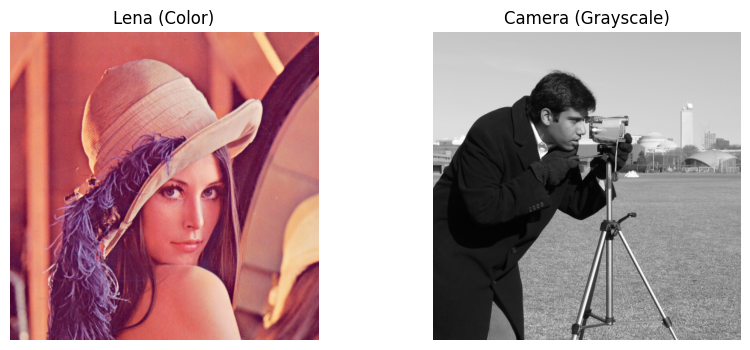

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.color import rgb2gray
import urllib.request

# Load Lena as a color image from URL
url_lena = 'http://www.image.ntua.gr/~tpar/LABimage/lena.png'
resp = urllib.request.urlopen(url_lena)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
lena_color = cv2.imdecode(image_data, cv2.IMREAD_COLOR)  # Read as color
lena_color = cv2.cvtColor(lena_color, cv2.COLOR_BGR2RGB)

# Load Camera image (grayscale) from skimage
camera = img_as_float(data.camera())

# Display original images for verification
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(lena_color)
plt.title('Lena (Color)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(camera, cmap='gray')
plt.title('Camera (Grayscale)')
plt.axis('off')
plt.show()




## 2. Creation and Display of the Gaussian Pyramid

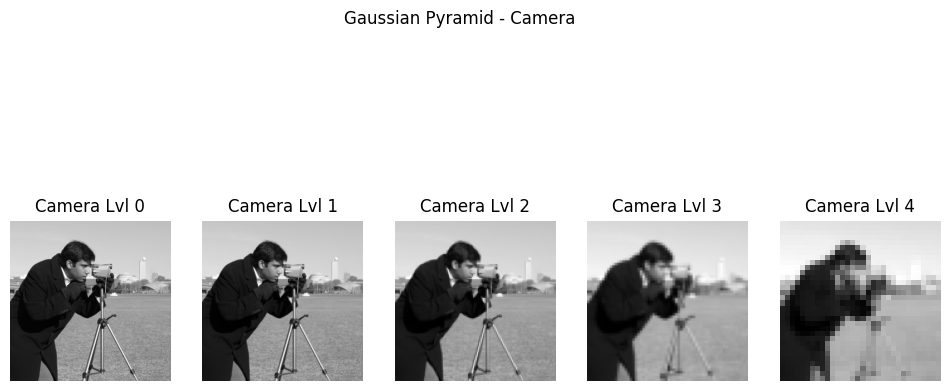

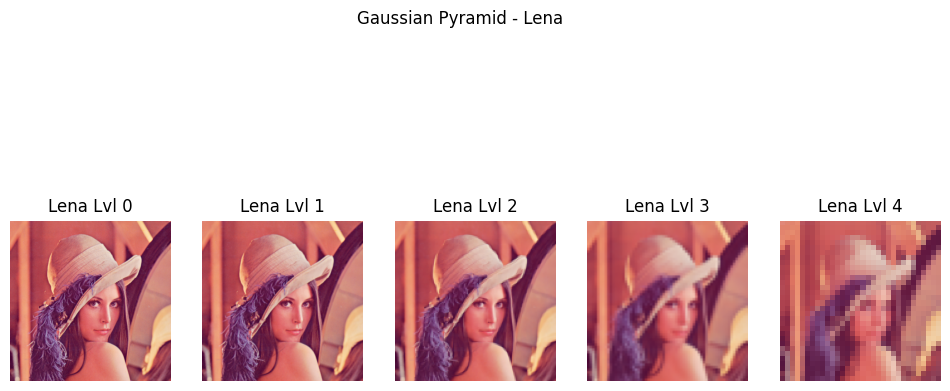

In [ ]:
# Parameters
a = 0.5
depth = 5

# Generate Gaussian pyramid for Camera (grayscale) and Lena (color)
camera_gauss = GPyramid(camera, a, depth)
lena_gauss = GPyramid(lena_color, a, depth)

# Display Gaussian pyramid levels for Camera
plt.figure(figsize=(12,6))
for i in range(depth):
    plt.subplot(1, depth, i+1)
    plt.imshow(camera_gauss[i], cmap='gray')
    plt.title(f'Camera Lvl {i}')
    plt.axis('off')
plt.suptitle("Gaussian Pyramid - Camera")
plt.show()

# Display Gaussian pyramid levels for Lena
plt.figure(figsize=(12,6))
for i in range(depth):
    plt.subplot(1, depth, i+1)
    # Clip values to [0,255] and convert to uint8 for visualization if needed
    lena_lvl = np.clip(lena_gauss[i], 0, 255).astype(np.uint8)
    plt.imshow(lena_lvl)
    plt.title(f'Lena Lvl {i}')
    plt.axis('off')
plt.suptitle("Gaussian Pyramid - Lena")
plt.show()


As we go to higher pyramid levels, the image becomes blurrier. This is expected, as applying the kernel each time we ascend a level acts as applying a low-pass filter.

## 3. Creation and Display of the Laplacian Pyramid

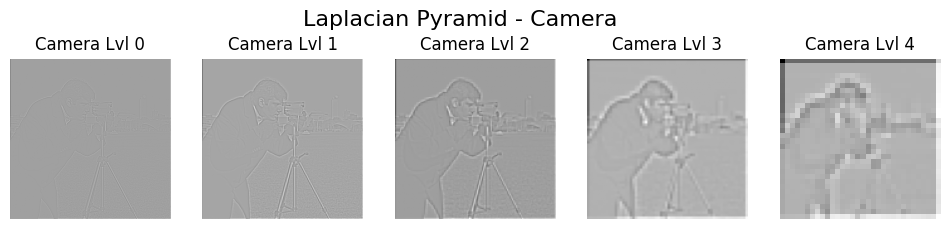

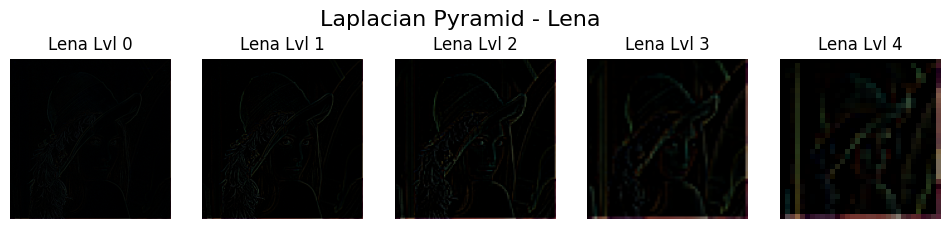

In [ ]:
# Generate Laplacian pyramid for Camera and Lena
camera_lap = LPyramid(camera, a, depth)
lena_lap = LPyramid(lena_color, a, depth)

# Display Laplacian pyramid levels for Camera
plt.figure(figsize=(12,6))
for i in range(depth):
    plt.subplot(1, depth, i+1)
    plt.imshow(camera_lap[i], cmap='gray')
    plt.title(f'Camera Lvl {i}', fontsize=12)
    plt.axis('off')
plt.suptitle("Laplacian Pyramid - Camera", fontsize=16, y=0.92)
plt.subplots_adjust(top=1.3)
plt.show()

# Display Laplacian pyramid levels for Lena
plt.figure(figsize=(12,6))
for i in range(depth):
    plt.subplot(1, depth, i+1)
    lena_lap_lvl = np.clip(lena_lap[i], 0, 255).astype(np.uint8)
    plt.imshow(lena_lap_lvl)
    plt.title(f'Lena Lvl {i}', fontsize=12)
    plt.axis('off')
plt.suptitle("Laplacian Pyramid - Lena", fontsize=16, y=0.92)
plt.subplots_adjust(top=1.3)
plt.show()


In the Laplacian pyramid, the features appear sharper as we ascend levels. This happens because at each level we subtract the expanded version of the next level from the current Gaussian image.

## 4. Reconstruction Test with Different 'a' Values

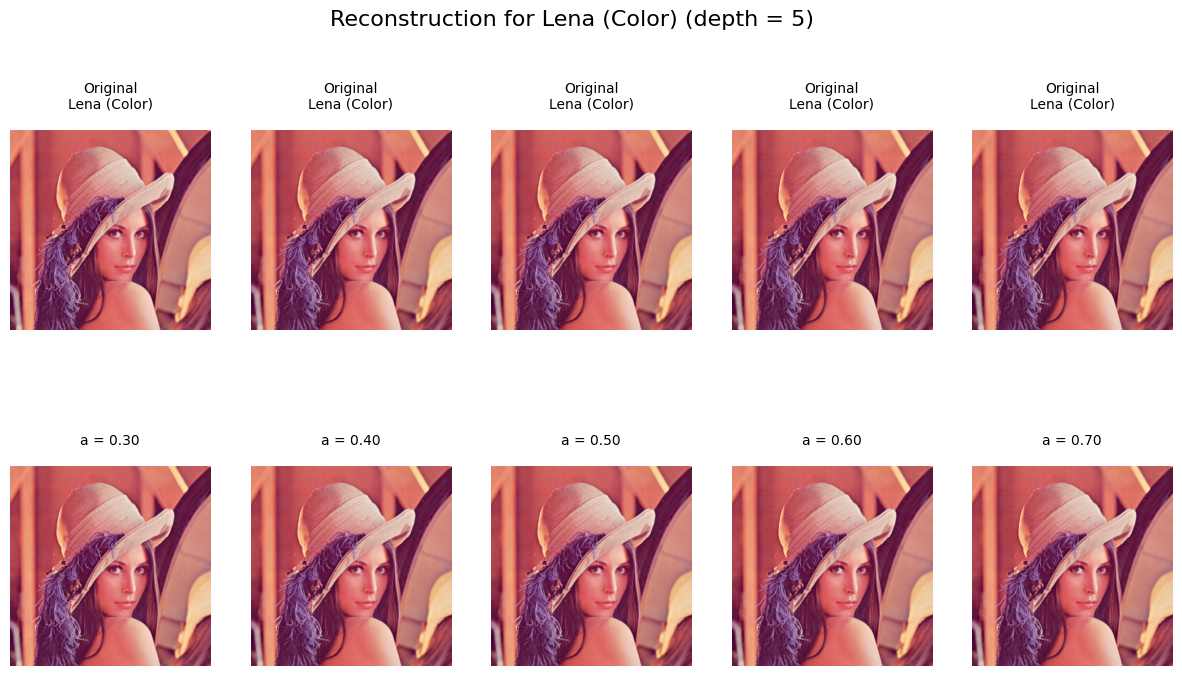

For Lena (Color) with a = 0.30: MSE = 7.438402865939347e-32
For Lena (Color) with a = 0.40: MSE = 1.0087258701430687e-31
For Lena (Color) with a = 0.50: MSE = 0.0
For Lena (Color) with a = 0.60: MSE = 1.8704162926781275e-29
For Lena (Color) with a = 0.70: MSE = 1.0183385225301573e-28


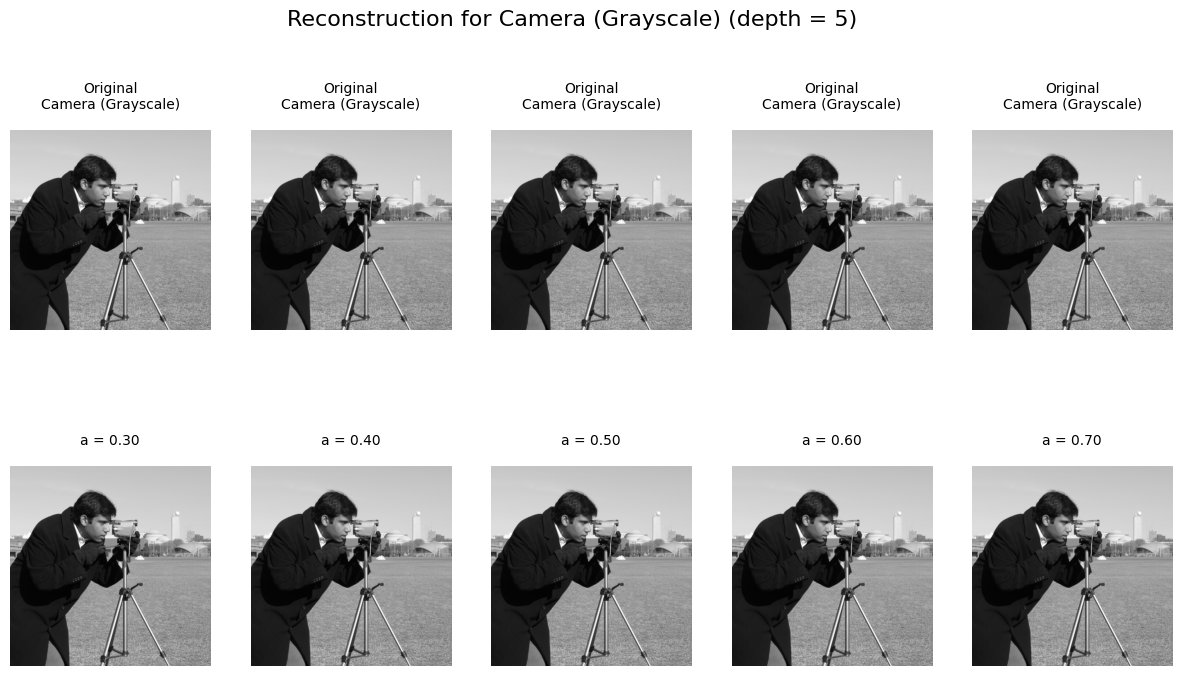

For Camera (Grayscale) with a = 0.30: MSE = 4.1058043211055106e-36
For Camera (Grayscale) with a = 0.40: MSE = 4.2625215952991226e-36
For Camera (Grayscale) with a = 0.50: MSE = 5.769381375133482e-36
For Camera (Grayscale) with a = 0.60: MSE = 4.635846892094521e-34
For Camera (Grayscale) with a = 0.70: MSE = 1.1723074783044722e-33


In [ ]:
# Define a range of a values (from 0.3 to 0.7) and a fixed pyramid depth.
a_values = np.linspace(0.3, 0.7, 5)
depth = 5

def test_reconstruction(image, image_name):
    """
    For each value of a in a_values, this function computes the Laplacian pyramid
    (using LPyramid) and then decodes it (using L_Pyramid_Decode). The original image
    and its reconstruction are displayed side by side.
    Before display, color images are converted to uint8.
    """
    plt.figure(figsize=(15,8))
    for i, a in enumerate(a_values):
        # Build the Laplacian pyramid for the given parameter a.
        lpyr = LPyramid(image, a, depth)
        # Reconstruct the image from the Laplacian pyramid.
        rec = L_Pyramid_Decode(lpyr, a)

        # Display the original image in the upper row.
        plt.subplot(2, len(a_values), i+1)
        if image.ndim == 3:
            # Convert to uint8 for proper display.
            plt.imshow(np.clip(image, 0, 255).astype(np.uint8))
        else:
            plt.imshow(image, cmap='gray')
        plt.title(f'Original\n{image_name}', pad=15, fontsize=10)
        plt.axis('off')

        # Display the reconstructed image in the lower row.
        plt.subplot(2, len(a_values), i+1+len(a_values))
        if rec.ndim == 3:
            plt.imshow(np.clip(rec, 0, 255).astype(np.uint8))
        else:
            plt.imshow(rec, cmap='gray')
        plt.title(f'a = {a:.2f}', pad=15, fontsize=10)
        plt.axis('off')

    plt.suptitle(f'Reconstruction for {image_name} (depth = {depth})', fontsize=16)
    plt.show()


def calculate_mse(original, decoded):
    original = original.astype(np.float64)
    decoded = decoded.astype(np.float64)
    return np.mean((original - decoded) ** 2)


# Test for Lena (Color)
test_reconstruction(lena_color, 'Lena (Color)')
for i, a in enumerate(a_values):
    lpyr = LPyramid(lena_color, a, depth)
    rec = L_Pyramid_Decode(lpyr, a)
    mse = calculate_mse(lena_color, rec)
    print(f"For Lena (Color) with a = {a:.2f}: MSE = {mse}")

# Test for Camera (Grayscale)
test_reconstruction(camera, 'Camera (Grayscale)')
for i, a in enumerate(a_values):
    lpyr = LPyramid(camera, a, depth)
    rec = L_Pyramid_Decode(lpyr, a)
    mse = calculate_mse(camera, rec)
    print(f"For Camera (Grayscale) with a = {a:.2f}: MSE = {mse}")


## 5. Reconstruction Test with Different Pyramid Depths

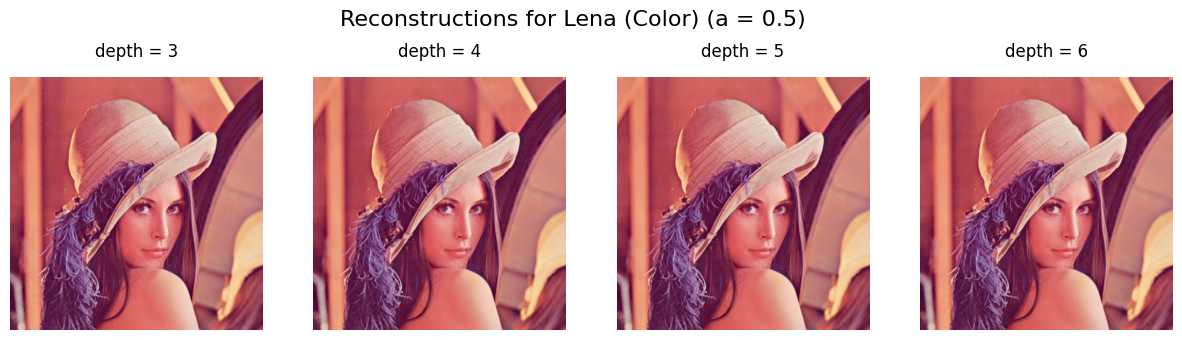

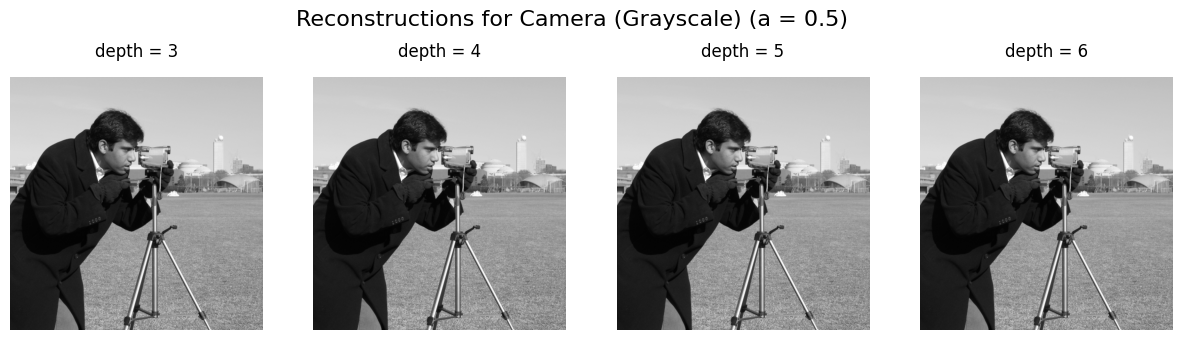

In [ ]:
# Define a range of depth values and a fixed a value.
depth_values = range(3, 7)
a_fixed = 0.5

def test_depth(image, image_name):

    plt.figure(figsize=(15,4))
    for i, d in enumerate(depth_values):
        lpyr = LPyramid(image, a_fixed, d)
        rec = L_Pyramid_Decode(lpyr, a_fixed)
        plt.subplot(1, len(depth_values), i+1)
        if rec.ndim == 3:
            # Convert to uint8 for proper display if color.
            plt.imshow(np.clip(rec, 0, 255).astype(np.uint8))
        else:
            plt.imshow(rec, cmap='gray')
        plt.title(f'depth = {d}', pad=15, fontsize=12)
        plt.axis('off')
    plt.suptitle(f'Reconstructions for {image_name} (a = {a_fixed})', fontsize=16)
    plt.show()

# Test for both Lena (Color) and Camera (Grayscale)
test_depth(lena_color, 'Lena (Color)')
test_depth(camera, 'Camera (Grayscale)')


## 6. Entropy Calculation Function Definition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

def H_entropy(pyramid):
    """
    Computes the Shannon entropy for each level in a pyramid.
    For each level, if the image is of floating point type and its max is ≤ 1,
    it is scaled to [0,255] before converting to uint8.
    Then, a histogram is computed and the Shannon entropy is calculated.

    Returns:
      A list of entropy values (one per pyramid level).
    """
    entropies = []
    for level in pyramid:
        # If the image is float and its maximum is ≤ 1, assume it's normalized and scale it.
        if np.issubdtype(level.dtype, np.floating) and level.max() <= 1:
            level_uint8 = np.clip(level * 255, 0, 255).astype(np.uint8)
        else:
            level_uint8 = np.clip(level, 0, 255).astype(np.uint8)
        pixels = level_uint8.flatten()
        total_pixels = len(pixels)
        counts = Counter(pixels)
        entropy = 0.0
        for count in counts.values():
            p = count / total_pixels
            entropy -= p * log2(p)
        entropies.append(entropy)
    return entropies


## 7. Entropy vs. 'a' (fixed depth = 5) for Camera and Lena Images

Entropy for Camera (Grayscale) for variable a:

For a = 0.3
  Level 0 : Entropy = 2.2212301370565317
  Level 1 : Entropy = 2.1358174900546456
  Level 2 : Entropy = 2.3576984477366114
  Level 3 : Entropy = 2.778964302704052
  Level 4 : Entropy = 3.4281547967669495
  Level 5 : Entropy = 6.4976652112123565

For a = 0.4
  Level 0 : Entropy = 2.124620144066744
  Level 1 : Entropy = 2.078359423441098
  Level 2 : Entropy = 2.3055544330649416
  Level 3 : Entropy = 2.6730161738331915
  Level 4 : Entropy = 3.299368476664403
  Level 5 : Entropy = 6.48866613885377

For a = 0.5
  Level 0 : Entropy = 1.9703704375920652
  Level 1 : Entropy = 1.9535186961851134
  Level 2 : Entropy = 2.159207044023555
  Level 3 : Entropy = 2.449557632481546
  Level 4 : Entropy = 2.981714975320291
  Level 5 : Entropy = 6.481497377277131

For a = 0.6
  Level 0 : Entropy = 1.9320801207437526
  Level 1 : Entropy = 2.044161930249586
  Level 2 : Entropy = 2.3282968727725817
  Level 3 : Entropy = 2.6414355640467746
  Level 4 

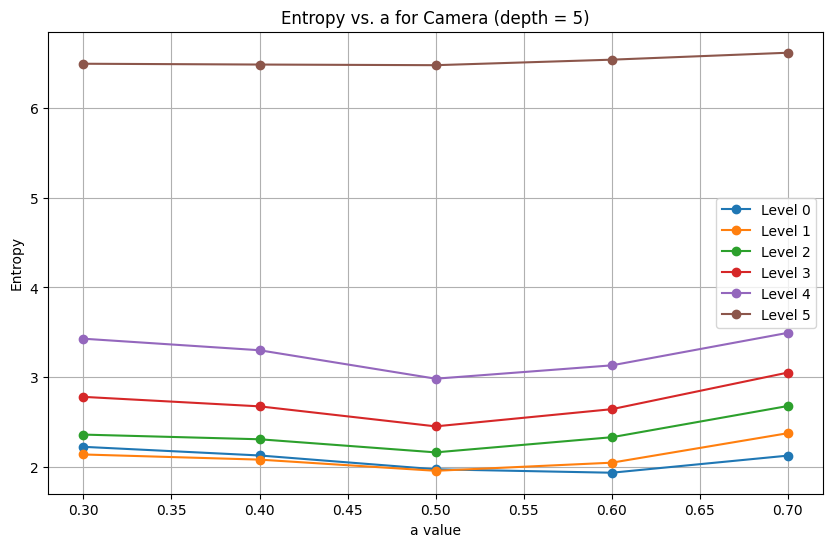

Entropy for Lena (Color) for variable a:

For a = 0.3
  Level 0 : Entropy = 2.5626074805233876
  Level 1 : Entropy = 2.42904087596895
  Level 2 : Entropy = 2.8930351112899717
  Level 3 : Entropy = 3.3347300390347887
  Level 4 : Entropy = 3.7008305993526056
  Level 5 : Entropy = 7.124504534941515

For a = 0.4
  Level 0 : Entropy = 2.4619682262264804
  Level 1 : Entropy = 2.3269687766233265
  Level 2 : Entropy = 2.765139548907596
  Level 3 : Entropy = 3.224322428473242
  Level 4 : Entropy = 3.6178214708919105
  Level 5 : Entropy = 7.170697157456761

For a = 0.5
  Level 0 : Entropy = 2.313168670484249
  Level 1 : Entropy = 2.1709627415421444
  Level 2 : Entropy = 2.5357432398035638
  Level 3 : Entropy = 3.0596177508516407
  Level 4 : Entropy = 3.4901077322918748
  Level 5 : Entropy = 7.233910574173556

For a = 0.6
  Level 0 : Entropy = 2.2262379723464525
  Level 1 : Entropy = 2.2755424218836784
  Level 2 : Entropy = 2.6531508783575712
  Level 3 : Entropy = 3.1947103080965604
  Level 4 : E

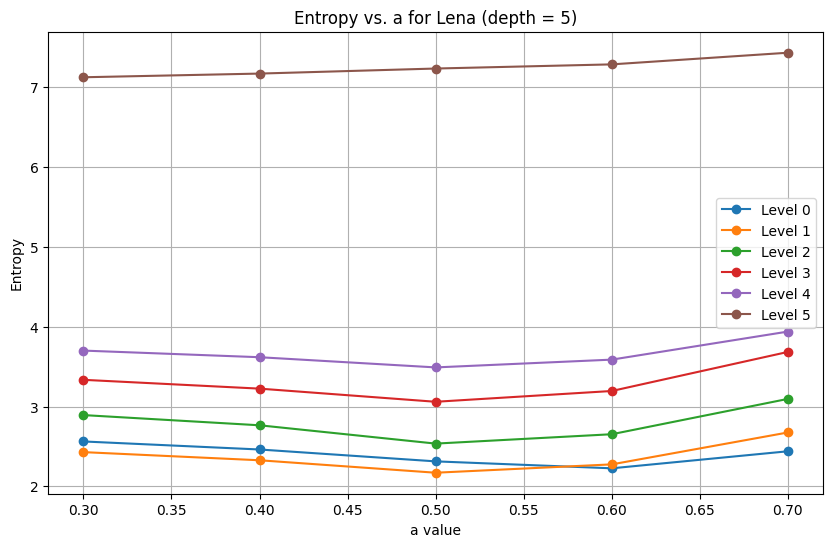

In [ ]:
# Define a list of a values (from 0.3 to 0.7) and set depth = 5.
a_list = [0.3, 0.4, 0.5, 0.6, 0.7]
depth_fixed = 5

# --- Για την εικόνα Camera (Grayscale) ---
camera_a_entropies = []
for a in a_list:
    lpyr = LPyramid(camera, a, depth_fixed)
    ent = H_entropy(lpyr)
    camera_a_entropies.append(ent)

print("Entropy for Camera (Grayscale) for variable a:")
for i, a in enumerate(a_list):
    print("\nFor a =", a)
    for level, entropy in enumerate(camera_a_entropies[i]):
        print("  Level", level, ": Entropy =", entropy)

# Plot entropy vs. a for each pyramid level (Camera)
camera_a_entropies = np.array(camera_a_entropies)  # shape: (len(a_list), depth+1)
plt.figure(figsize=(10,6))
for level in range(camera_a_entropies.shape[1]):
    plt.plot(a_list, camera_a_entropies[:, level], marker='o', label="Level " + str(level))
plt.xlabel("a value")
plt.ylabel("Entropy")
plt.title("Entropy vs. a for Camera (depth = " + str(depth_fixed) + ")")
plt.legend()
plt.grid(True)
plt.show()


# --- Για την εικόνα Lena (Color) ---
lena_a_entropies = []
for a in a_list:
    lpyr = LPyramid(lena_color, a, depth_fixed)
    ent = H_entropy(lpyr)
    lena_a_entropies.append(ent)

print("Entropy for Lena (Color) for variable a:")
for i, a in enumerate(a_list):
    print("\nFor a =", a)
    for level, entropy in enumerate(lena_a_entropies[i]):
        print("  Level", level, ": Entropy =", entropy)

plt.figure(figsize=(10,6))
lena_a_entropies = np.array(lena_a_entropies)
for level in range(lena_a_entropies.shape[1]):
    plt.plot(a_list, lena_a_entropies[:, level], marker='o', label="Level " + str(level))
plt.xlabel("a value")
plt.ylabel("Entropy")
plt.title("Entropy vs. a for Lena (depth = " + str(depth_fixed) + ")")
plt.legend()
plt.grid(True)
plt.show()


**Observation:**  
- Entropy decreases until about a = 0.5 and then increases.
- This pattern is observed in all pyramid levels.

## 8. Entropy vs. Depth (fixed a = 0.5) for Camera and Lena Images

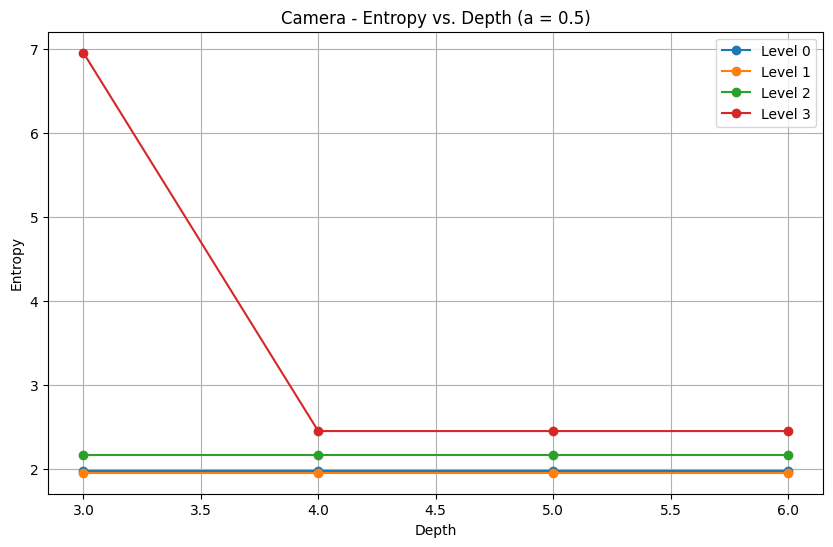

Entropy for Camera (Grayscale) for variable depth (a = 0.5):

For depth = 3
  Level 0 : Entropy = 1.9703704375920652
  Level 1 : Entropy = 1.9535186961851134
  Level 2 : Entropy = 2.159207044023555
  Level 3 : Entropy = 6.953746814857871

For depth = 4
  Level 0 : Entropy = 1.9703704375920652
  Level 1 : Entropy = 1.9535186961851134
  Level 2 : Entropy = 2.159207044023555
  Level 3 : Entropy = 2.449557632481546

For depth = 5
  Level 0 : Entropy = 1.9703704375920652
  Level 1 : Entropy = 1.9535186961851134
  Level 2 : Entropy = 2.159207044023555
  Level 3 : Entropy = 2.449557632481546

For depth = 6
  Level 0 : Entropy = 1.9703704375920652
  Level 1 : Entropy = 1.9535186961851134
  Level 2 : Entropy = 2.159207044023555
  Level 3 : Entropy = 2.449557632481546


In [ ]:
# Define depth values and fixed a.
depth_list = [3, 4, 5, 6]
a_fixed = 0.5

# For each depth, compute the Laplacian pyramid and the entropies.
camera_depth_entropies = []
for d in depth_list:
    lpyr = LPyramid(camera, a_fixed, d)
    ent = H_entropy(lpyr)
    camera_depth_entropies.append(ent)

# Since for each depth we have d+1 levels, the minimum common number is for d=3 -> 4 levels.
common_levels = 4

# For each level (0 to 3), collect the entropy for each depth value.
entropy_vs_depth = {level: [] for level in range(common_levels)}
for ent_list in camera_depth_entropies:
    for level in range(common_levels):
        entropy_vs_depth[level].append(ent_list[level])

# Plot for the Camera image
plt.figure(figsize=(10,6))
for level in range(common_levels):
    plt.plot(depth_list, entropy_vs_depth[level], marker='o', label=f'Level {level}')
plt.xlabel("Depth")
plt.ylabel("Entropy")
plt.title("Camera - Entropy vs. Depth (a = " + str(a_fixed) + ")")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("Entropy for Camera (Grayscale) for variable depth (a = " + str(a_fixed) + "):")
for i, d in enumerate(depth_list):
    print("\nFor depth =", d)
    for level in range(common_levels):
        print("  Level", level, ": Entropy =", camera_depth_entropies[i][level])


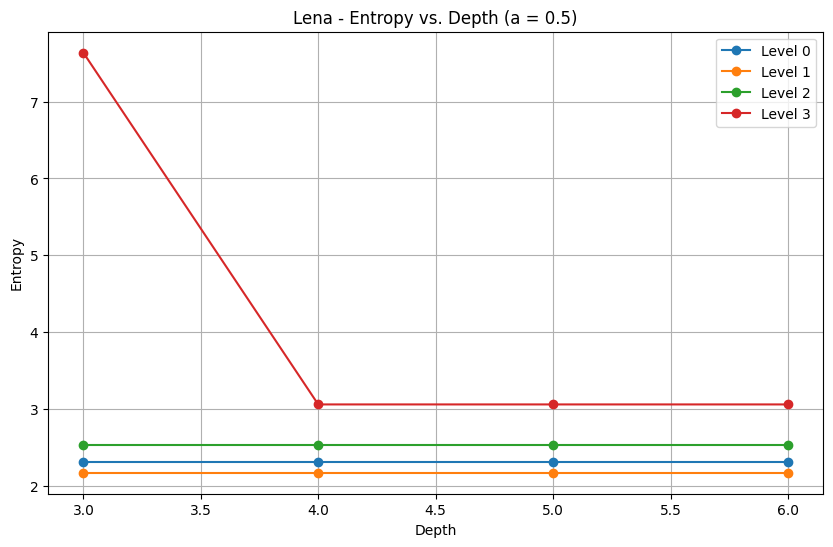

Entropy for Lena (Color) for variable depth (a = 0.5):

For depth = 3
  Level 0 : Entropy = 2.313168670484249
  Level 1 : Entropy = 2.1709627415421444
  Level 2 : Entropy = 2.5357432398035638
  Level 3 : Entropy = 7.635959683642114

For depth = 4
  Level 0 : Entropy = 2.313168670484249
  Level 1 : Entropy = 2.1709627415421444
  Level 2 : Entropy = 2.5357432398035638
  Level 3 : Entropy = 3.0596177508516407

For depth = 5
  Level 0 : Entropy = 2.313168670484249
  Level 1 : Entropy = 2.1709627415421444
  Level 2 : Entropy = 2.5357432398035638
  Level 3 : Entropy = 3.0596177508516407

For depth = 6
  Level 0 : Entropy = 2.313168670484249
  Level 1 : Entropy = 2.1709627415421444
  Level 2 : Entropy = 2.5357432398035638
  Level 3 : Entropy = 3.0596177508516407


In [ ]:
# Define depth values and fixed a.
depth_list = [3, 4, 5, 6]
a_fixed = 0.5

# For each depth, compute the Laplacian pyramid and the entropies.
lena_depth_entropies = []
for d in depth_list:
    lpyr = LPyramid(lena_color, a_fixed, d)
    ent = H_entropy(lpyr)
    lena_depth_entropies.append(ent)

# The minimum common number of levels is 4 (for d=3)
common_levels = 4

# Collect entropy for each level with respect to depth.
entropy_vs_depth = {level: [] for level in range(common_levels)}
for ent_list in lena_depth_entropies:
    for level in range(common_levels):
        entropy_vs_depth[level].append(ent_list[level])

# Plot for the Lena image
plt.figure(figsize=(10,6))
for level in range(common_levels):
    plt.plot(depth_list, entropy_vs_depth[level], marker='o', label=f'Level {level}')
plt.xlabel("Depth")
plt.ylabel("Entropy")
plt.title("Lena - Entropy vs. Depth (a = " + str(a_fixed) + ")")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("Entropy for Lena (Color) for variable depth (a = " + str(a_fixed) + "):")
for i, d in enumerate(depth_list):
    print("\nFor depth =", d)
    for level in range(common_levels):
        print("  Level", level, ": Entropy =", lena_depth_entropies[i][level])


**Observation:**  
- Depth does not significantly affect entropy.
- However, higher depths slightly decrease the entropy of the highest pyramid levels.

# **Παρατηρήσεις (4,5)**

4.Παρατηρούμε ότι το α αρχικά με την αύξηση του ρίχνει την εντροπία μέχρι περίπου το a = 0.5 από εκεί και πέρα η εντροπία αυξάνεται. Αυτό το φαινόμενο παρατηρείται σε όλα τα levels της πυραμίδας αντίστοιχα.

Παρατηρούμε επίσης ότι το depth δεν επηρεάζει ιδιαίτερα την εντροπία, αν και βλέπουμε ότι όσο μεγλύτερο το βάθος τόσο μικραίνει η εντροπία του τελευταίου επιπέδου.

5.Παρατηρούμε στα διαγράμματα παραπάνω ότι το βέλτιστο α για όλα τα επίπεδα είναι το 0.5 καθώς παρουσιάζει τη μικρότερη εντροπία.

#**6.**

## 9. Quantization per Pyramid Level

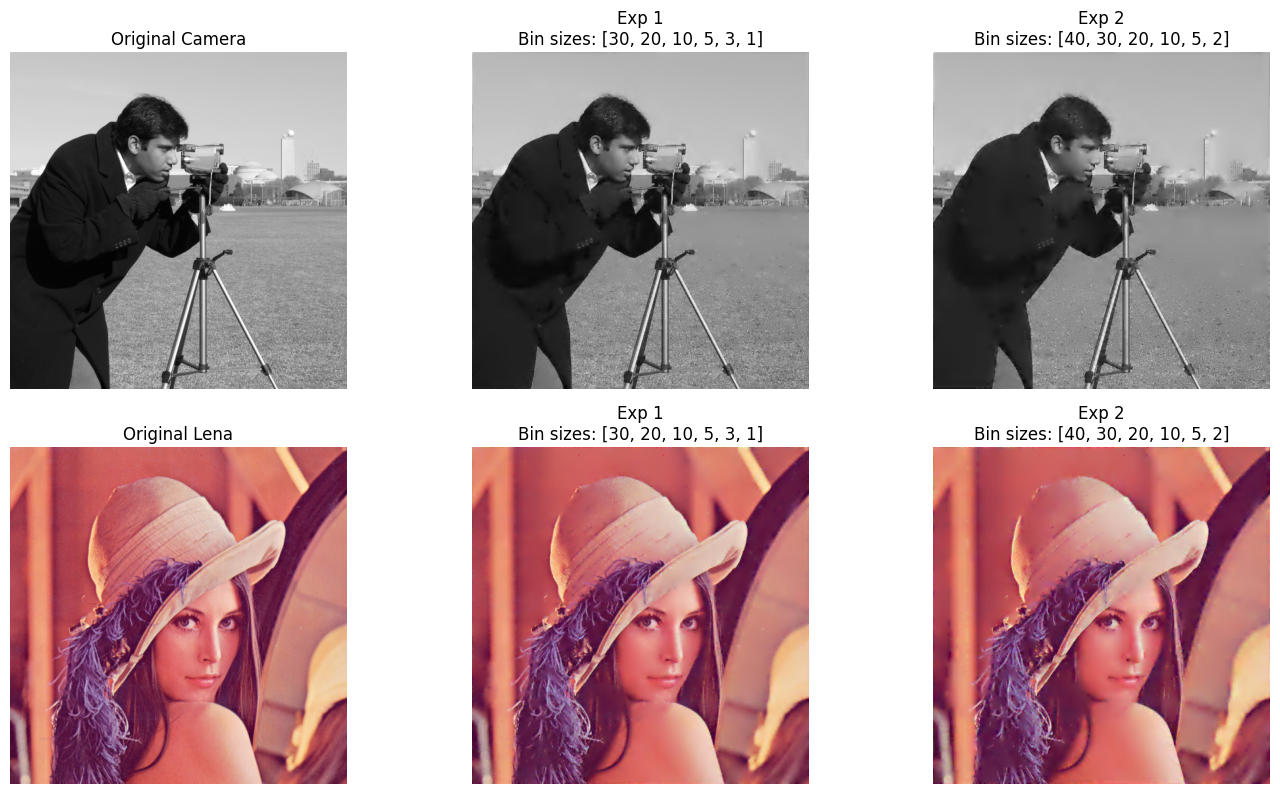

Image Entropies:
Camera - Exp 1: 7.160197014264679
Camera - Exp 2: 7.095490958750646
Lena   - Exp 1: 7.714522610146652
Lena   - Exp 2: 7.70369509467611


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.color import rgb2gray
import urllib.request
from collections import Counter
from math import log2

# --- Load Images ---
# Load Lena as a color image from URL
url_lena = 'http://www.image.ntua.gr/~tpar/LABimage/lena.png'
resp = urllib.request.urlopen(url_lena)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
lena_color = cv2.imdecode(image_data, cv2.IMREAD_COLOR)  # Read as color
lena_color = cv2.cvtColor(lena_color, cv2.COLOR_BGR2RGB)

# Load Camera image (grayscale) from skimage (originally float with values in [0,1])
camera = img_as_float(data.camera())
# Convert camera to uint8 (values in [0,255])
if camera.dtype != np.uint8 or camera.max() <= 1:
    camera_proc = np.clip(camera * 255, 0, 255).astype(np.uint8)
else:
    camera_proc = camera

# --- Define Level-Dependent Quantization Function ---
def L_Quantization_by_levels(lpyr, bin_sizes):
    """
    Quantizes each level of the Laplacian pyramid using level-specific bin sizes.
    For level i, the quantized level is computed as:
       Q_i = bin_sizes[i] * round(L_i / bin_sizes[i])

    Parameters:
      lpyr      : List of Laplacian pyramid levels.
      bin_sizes : List of bin sizes (one per level). Lower (fine) levels use larger bins,
                  and higher (coarser) levels use smaller bins.

    Returns:
      A list of quantized pyramid levels.
    """
    quantized_pyr = []
    for i, level in enumerate(lpyr):
        Q = bin_sizes[i] * np.round(level / bin_sizes[i])
        quantized_pyr.append(Q)
    return quantized_pyr

# --- Define Image Entropy Function ---
def image_entropy(image):
    """
    Computes the Shannon entropy of an image.
    The image is clipped and converted to uint8, flattened, and its histogram is used
    to calculate the entropy.
    """
    image_uint8 = np.clip(image, 0, 255).astype(np.uint8)
    pixels = image_uint8.flatten()
    total_pixels = len(pixels)
    counts = Counter(pixels)
    entropy = 0
    for count in counts.values():
        p = count / total_pixels
        entropy -= p * log2(p)
    return entropy

# --- Set Parameters for the Experiment ---
a_value = 0.5
depth = 5  # This produces 6 levels (0 to 5)

# Build Laplacian pyramids for Camera and Lena.
# Use camera_proc (converted to uint8) for the Camera image.
camera_lp = LPyramid(camera_proc, a_value, depth)
lena_lp = LPyramid(lena_color, a_value, depth)

# Define two experiments with level-dependent bin sizes.
# Experiment 1: Larger bins at lower levels, smaller at higher levels.
bin_sizes_exp1 = [30, 20, 10, 5, 3, 1]  # for levels 0..5
# Experiment 2: Alternative set.
bin_sizes_exp2 = [40, 30, 20, 10, 5, 2]  # for levels 0..5

# Quantize the Laplacian pyramids with these bin sizes.
quantized_camera_lp_exp1 = L_Quantization_by_levels(camera_lp, bin_sizes_exp1)
quantized_lena_lp_exp1   = L_Quantization_by_levels(lena_lp, bin_sizes_exp1)

quantized_camera_lp_exp2 = L_Quantization_by_levels(camera_lp, bin_sizes_exp2)
quantized_lena_lp_exp2   = L_Quantization_by_levels(lena_lp, bin_sizes_exp2)

# Reconstruct images from the quantized pyramids.
reconstructed_camera_exp1 = L_Pyramid_Decode(quantized_camera_lp_exp1, a_value)
reconstructed_lena_exp1   = L_Pyramid_Decode(quantized_lena_lp_exp1, a_value)

reconstructed_camera_exp2 = L_Pyramid_Decode(quantized_camera_lp_exp2, a_value)
reconstructed_lena_exp2   = L_Pyramid_Decode(quantized_lena_lp_exp2, a_value)

# --- Display the Results ---
plt.figure(figsize=(14, 12))

# Display results for the Camera image.
plt.subplot(3, 3, 1)
plt.imshow(camera_proc, cmap='gray')
plt.title("Original Camera")
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(reconstructed_camera_exp1, cmap='gray')
plt.title("Exp 1\nBin sizes: " + str(bin_sizes_exp1))
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(reconstructed_camera_exp2, cmap='gray')
plt.title("Exp 2\nBin sizes: " + str(bin_sizes_exp2))
plt.axis('off')

# Display results for the Lena image.
plt.subplot(3, 3, 4)
plt.imshow(lena_color)
plt.title("Original Lena")
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(np.clip(reconstructed_lena_exp1, 0, 255).astype(np.uint8))
plt.title("Exp 1\nBin sizes: " + str(bin_sizes_exp1))
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(np.clip(reconstructed_lena_exp2, 0, 255).astype(np.uint8))
plt.title("Exp 2\nBin sizes: " + str(bin_sizes_exp2))
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Compute and Print Image Entropies ---
H_camera_exp1 = image_entropy(reconstructed_camera_exp1)
H_camera_exp2 = image_entropy(reconstructed_camera_exp2)
H_lena_exp1   = image_entropy(reconstructed_lena_exp1)
H_lena_exp2   = image_entropy(reconstructed_lena_exp2)

print("Image Entropies:")
print("Camera - Exp 1:", H_camera_exp1)
print("Camera - Exp 2:", H_camera_exp2)
print("Lena   - Exp 1:", H_lena_exp1)
print("Lena   - Exp 2:", H_lena_exp2)


**Observation:**  
- Larger bin sizes degrade the visual result but reduce entropy.
- This is expected because larger bins cause more pixels to share the same value (the bin's median), leading to a loss of visual information but reduced uncertainty (entropy).